<a href="https://colab.research.google.com/github/snikhil17/NLP_course_Simplilearn/blob/main/Assignments/ML%20Revision_1/ML_Revision_1_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

- Cancer Detection Modelling (Label: diagnosis, Features: remaining columns except id column)

- Deploy two best model based on the following criteria

  - Model1: Get the best model based on Confusion Matrix and Numerical Metrics
  - Model2: Get the best model based on Viz Metrics


- Visualize the decision regions of the generated model based on two features that has highest significance in the dataset with respect to the label.

## **Hint:**
- To find the two best features, you can use support method using SBM that you
	have learned in Feature Engineering class :)

# **Approach:**

---
1. Aquiring Data
2. Load required Libraries and Data
3. Checking for missing, duplicates values and constant variables (variable with only 1 value)
4. Dropping ``id`` variable as given in problem statement 
5. EDA
  - Outliers detection and treatment
  - Check distribution
6. Correlation and heatmap of Variables
7. Encoding target variable i.e.``diagnosis`` to numeric.
8. Selecting Features by dropping multi-collinear variables. threshold = 0.85
9. Training 3 Models (RandomForestClassifier, LogisticRegression and SGDClassifier) and checking:
  - Is model Generalized?
  - If Generalized model: Model can be deployed?
  - Selected Top-2 Features from the model which could be used for deployment.
  - **Select Model-1 and Model-2** based on criteria mentioned in question.
  - Further use them to find top-2 parameters.
10. Using RFE and select_from_model from feature_selection module to obtain top-2 features
11. Trained models using best top-2 Variables obtained from multi-collinear variable eliminiation, RFE and select_from_model. Selected the best 2 variables:
  - Checked if model is still generalized
  - Can model be deployed? i.e. test_prediction_score > CL decided
12. Conclusion
13. Deployement Code:
  - Using a row randomly and predicting the model on that. (only top-2 variables were used)
  - Randomly taking inputs from user for top-2 variables and predicting the model.




## **1. Aquire Data**

In [1]:
!wget https://raw.githubusercontent.com/snikhil17/NLP_course_Simplilearn/main/Assignments/ML%20Revision_1/cancer.csv

--2021-11-30 11:31:08--  https://raw.githubusercontent.com/snikhil17/NLP_course_Simplilearn/main/Assignments/ML%20Revision_1/cancer.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124523 (122K) [text/plain]
Saving to: ‘cancer.csv’

cancer.csv          100%[===================>] 121.60K  --.-KB/s    in 0.02s   

2021-11-30 11:31:08 (5.87 MB/s) - ‘cancer.csv’ saved [124523/124523]



## **2. Load required Libraries and Data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)

from sklearn import metrics
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,points_se,symmetry_se,dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,0.2360,0.6656,1.670,17.43,0.008045,0.011800,0.01683,0.012410,0.01924,0.002248,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
1,8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,0.4505,1.1970,3.430,27.10,0.007470,0.035810,0.03354,0.013650,0.03504,0.003318,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
2,905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,0.1967,1.3870,1.342,13.54,0.005158,0.009355,0.01056,0.007483,0.01718,0.002198,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
3,868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,0.3384,1.3430,1.851,26.33,0.011270,0.034980,0.02187,0.019650,0.01580,0.003442,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
4,9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,0.1783,0.4125,1.338,17.72,0.005012,0.014850,0.01551,0.009155,0.01647,0.001767,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


## **3. Checking for missing, duplicates values and constant variables (variable with only 1 value)**

In [4]:
print(df.isnull().sum().sum())    # checking null values
print(df.duplicated().sum().sum())# Checking duplicates
print(int(len(df.nunique()) == 1))# Checking Constant Variables

0
0
0


## **4. Dropping ``id`` variable as given in problem statement**

In [5]:
# Dropping id column
df.drop('id', axis = 1, inplace = True)

## **5. EDA**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius_mean        569 non-null    float64
 2   texture_mean       569 non-null    float64
 3   perimeter_mean     569 non-null    float64
 4   area_mean          569 non-null    float64
 5   smoothness_mean    569 non-null    float64
 6   compactness_mean   569 non-null    float64
 7   concavity_mean     569 non-null    float64
 8   points_mean        569 non-null    float64
 9   symmetry_mean      569 non-null    float64
 10  dimension_mean     569 non-null    float64
 11  radius_se          569 non-null    float64
 12  texture_se         569 non-null    float64
 13  perimeter_se       569 non-null    float64
 14  area_se            569 non-null    float64
 15  smoothness_se      569 non-null    float64
 16  compactness_se     569 non

### **Detecting outliers** 

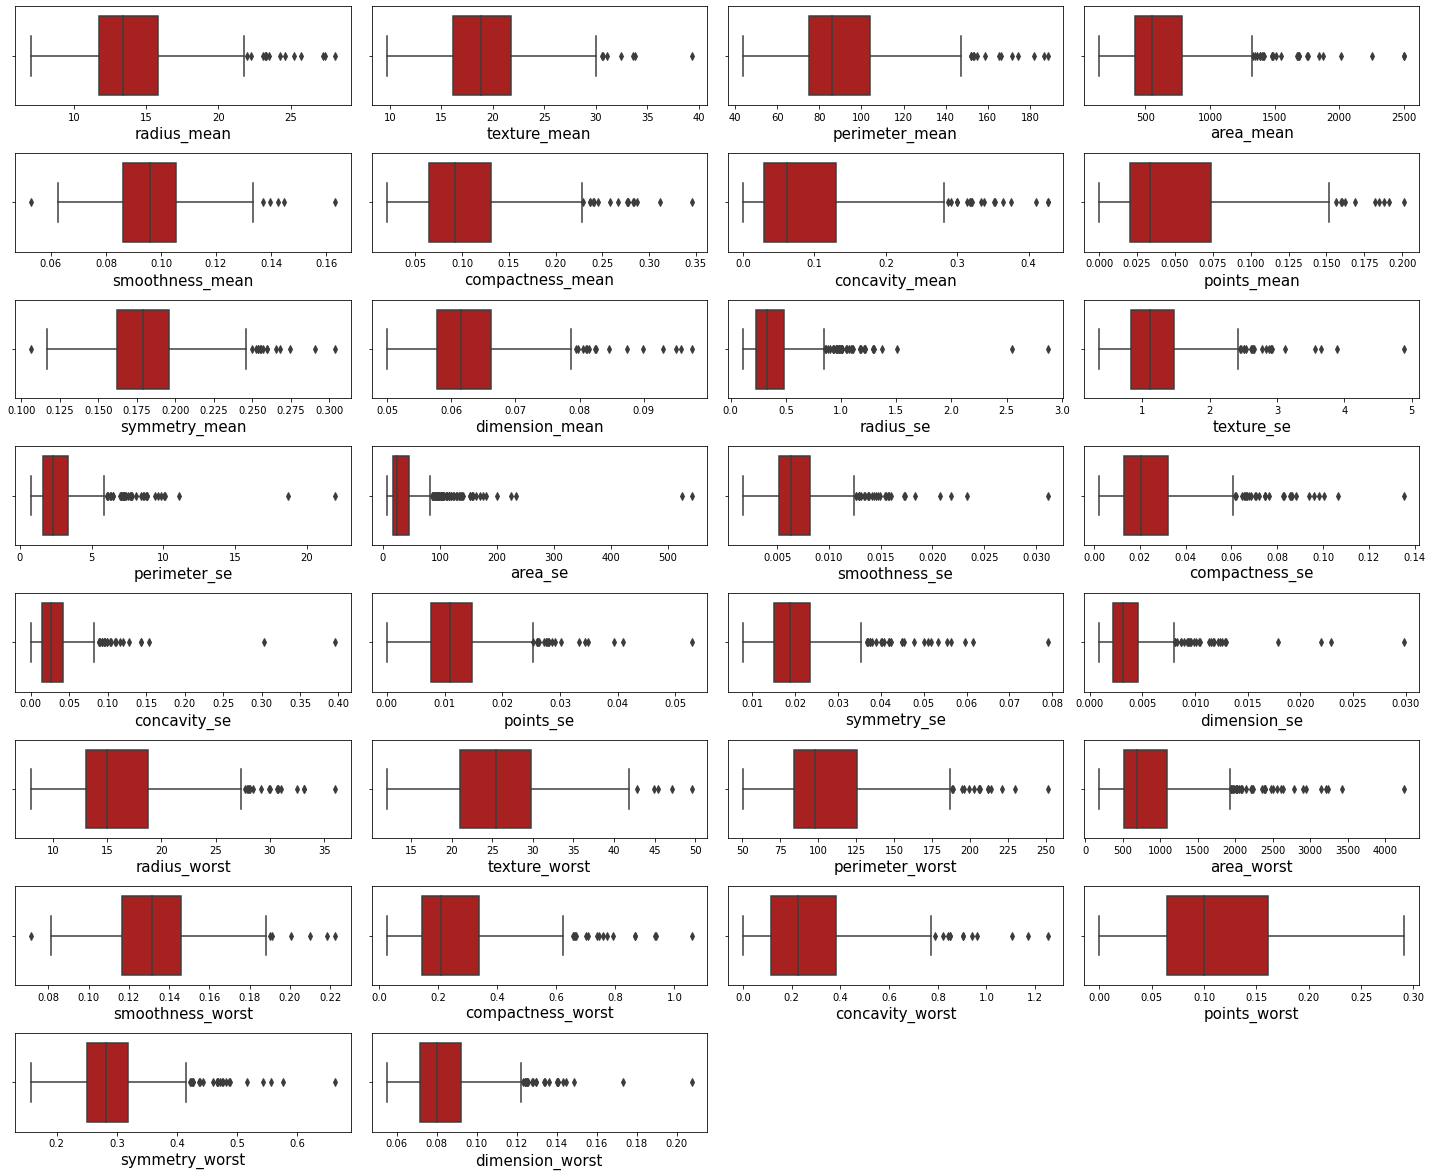

In [7]:
plt.figure(figsize = (20,20))
for i in enumerate(df.drop(['diagnosis'], axis = 1).columns):

  plt.subplot(10,4,i[0]+1)
  sns.boxplot(df[i[1]], color='#bd0b0b')
  plt.xlabel(i[1],fontsize = 15)
  plt.tight_layout()


### **Treating outliers using Capping (0.99) and Flooring (0.01)**


In [8]:
outliers_cols = []
for col in df.drop('diagnosis', axis = 1).columns:
  q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
  iqr = q75 - q25
  outlier_th = iqr*1.5
  lower_th = q25 - outlier_th
  upper_th = q75 - outlier_th 
  if any(df[col].values < lower_th) or any(df[col].values > upper_th):
    outliers_cols.append(col)

print(outliers_cols)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'points_se', 'symmetry_se', 'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_worst']


In [9]:
for col in outliers_cols:
  percentiles = df[col].quantile([0.01, 0.99]).values
  df[col] = np.clip(df[col], percentiles[0], percentiles[1])



### **Checking the boxplots after taking care of Outliers**

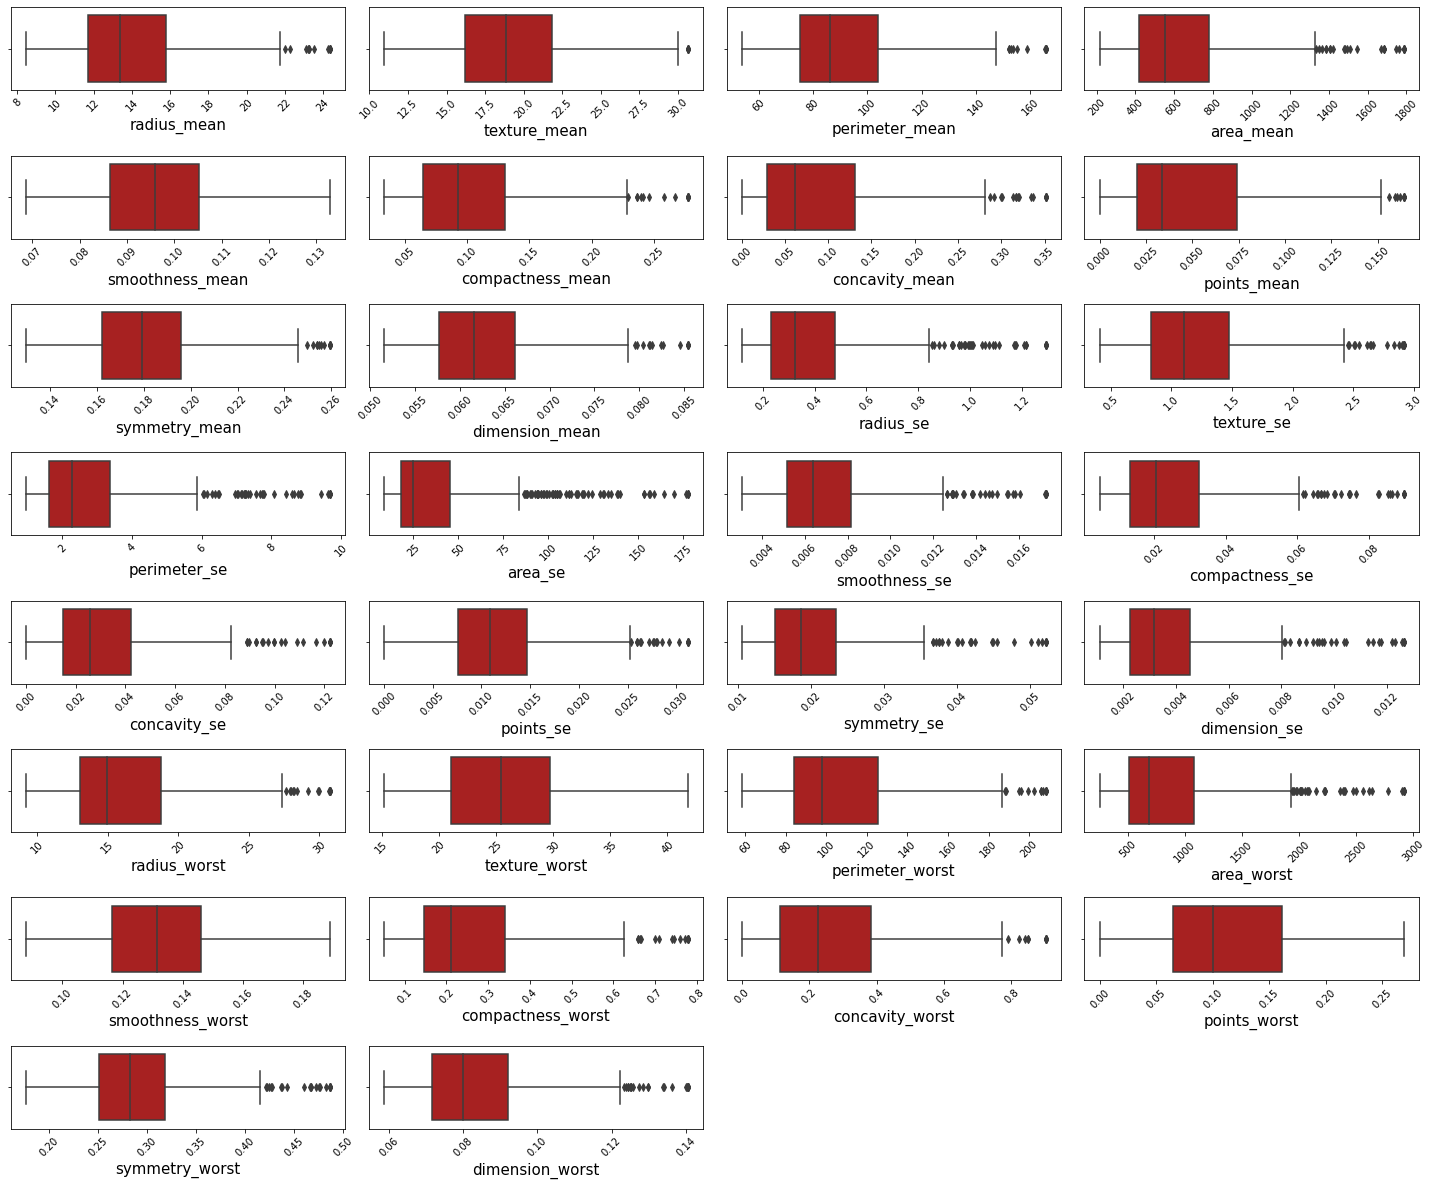

In [10]:
plt.figure(figsize = (20,20))
for i in enumerate(df.drop(['diagnosis'], axis = 1).columns):

  plt.subplot(10,4,i[0]+1)
  sns.boxplot(df[i[1]], color='#bd0b0b')
  plt.xlabel(i[1],fontsize = 15)
  plt.tight_layout()
  plt.xticks(rotation = 45)


### **Check the distribution**

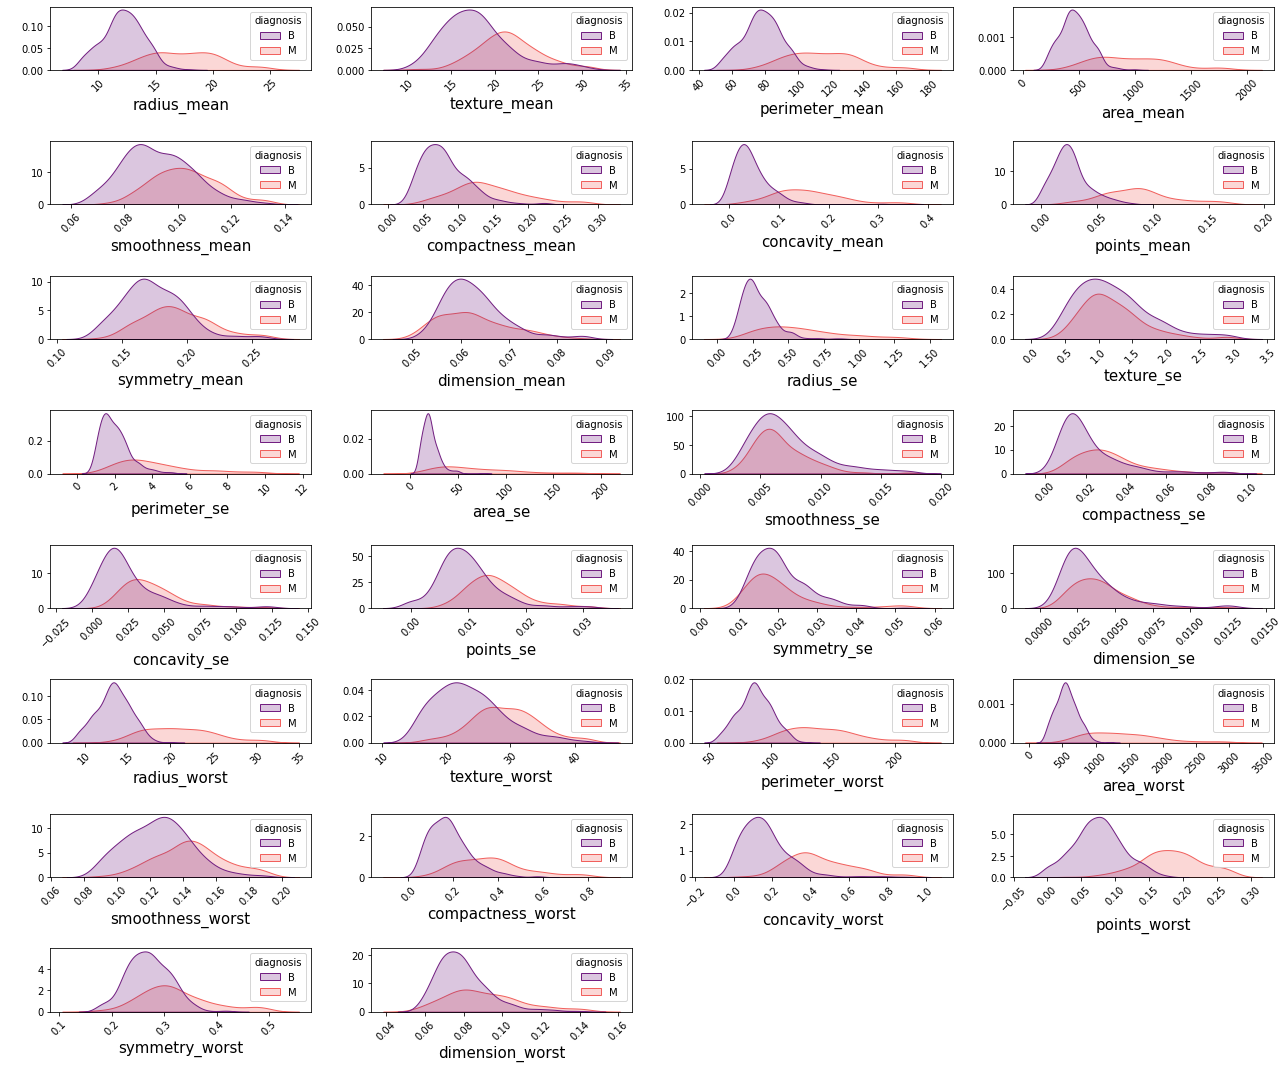

In [11]:
plt.figure(figsize = (18,18))
for i in enumerate(df.drop(['diagnosis'], axis = 1).columns):
  plt.subplot(10,4,i[0]+1)
  sns.kdeplot(data = df, x = i[1], hue = 'diagnosis', fill = 'magma', palette = 'magma' )
  plt.xlabel(i[1],fontsize = 15)
  plt.ylabel(" ")
  plt.xticks(rotation = 45)  
  plt.tight_layout()

In [12]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

## **Observations:** 

---
- Variables like: radius_mean, texture_mean, perimeter_mean, points_worst etc columns clearly show that when value/units are small then the mass is benign (B) else malignant (M)
- Varibles like: smoothness_mean, texture_se, smoothness_se, symmetry_se, dimension_worst etc have B and M overlapped which means they are difficult to interpret visually w.r.t target variable (diagnosis)
- Data is unbalanced hence we can oversample or undersample the data.

# **9. Training 3 Models** 
- **RandomForestClassifier, LogisticRegression and SGDClassifier** and checking:
  - Is model Generalized?
    - Data is unbalanced: **use accuracy to check generalization.**
  - If Generalized model: Check the quality and decide if model can be deployed.
    - Check **confusion matrix and classification report(f1-score)**
  - Criteria for selecting model will be **Confusion Matrix and Numerical Matrix**

In [13]:
"""Setting up data for train-test split"""
X = df.drop(['diagnosis'], axis =1)
Y = df.diagnosis 

"""Performing Train-Test Split"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=7 )

"""Standardizing the data"""
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

RandomForestClassifier


 RandomForestClassifier(max_depth=7, n_estimators=10, random_state=7) NO GOOD
RandomForestClassifier(max_depth=7, n_estimators=10, random_state=7) is not a Genralized Model. 
- We cannot consider this model for deployment.     
- Either accuracy_score_test < accuracy_score_train OR accuracy_score_test < CL 

accuracy_score_train: 0.9974874371859297
accuracy_score_test: 0.9883040935672515
CL decided: 0.85
No Further Action for model: RandomForestClassifier(max_depth=7, n_estimators=10, random_state=7)


SGDClassifier


SGDClassifier(loss='log', random_state=7) is generalized because accuracy_score_test > accuracy_score_train AND accuracy_score_test > CL
accuracy_score_train: 0.9698492462311558
accuracy_score_test: 0.9824561403508771
CL decided: 0.85


Since Model is generalized. Let's check Confusion Matrix and Classification Report


Classification report of Train Data: 
              precision    recall  f1-score   support

           B       0.98      0.97   

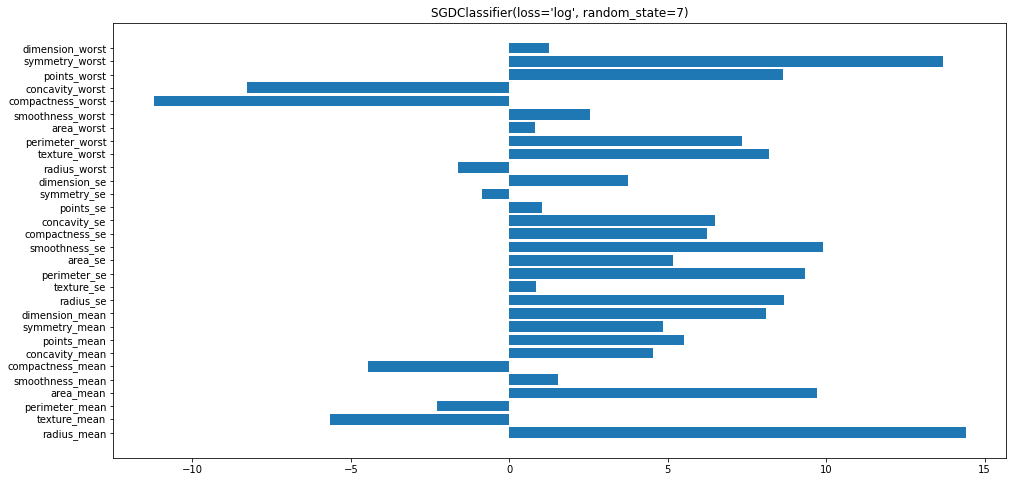

texture_worst        14.396875
area_se              13.685207
points_mean           9.903577
symmetry_worst        9.703862
points_worst          9.333449
radius_se             8.666947
area_worst            8.630963
concavity_worst       8.200891
radius_worst          8.095129
concavity_se          7.358119
perimeter_se          6.478587
perimeter_worst       6.226693
smoothness_se         5.524934
points_se             5.167996
smoothness_mean       4.839346
smoothness_worst      4.526486
dimension_se          3.733683
compactness_worst     2.561396
symmetry_se           1.525580
area_mean             1.267888
perimeter_mean        1.018855
radius_mean           0.830587
concavity_mean        0.823984
dimension_worst      -0.864719
dimension_mean       -1.631259
texture_mean         -2.286786
symmetry_mean        -4.453676
texture_se           -5.673770
compactness_mean     -8.264053
compactness_se      -11.215619
dtype: float64



LogisticRegression


LogisticRegression(random_state=7) is generalized because accuracy_score_test > accuracy_score_train AND accuracy_score_test > CL
accuracy_score_train: 0.9899497487437185
accuracy_score_test: 0.9941520467836257
CL decided: 0.85


Since Model is generalized. Let's check Confusion Matrix and Classification Report


Classification report of Train Data: 
              precision    recall  f1-score   support

           B       0.98      1.00      0.99       250
           M       1.00      0.97      0.99       148

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398


Classification report of Test Data: 
              precision    recall  f1-score   support

           B       0.99      1.00      1.00       107
           M       1.00      0.98      0.99        64

    accuracy                           0.99       171
   macro avg       1.00      0.99      0.

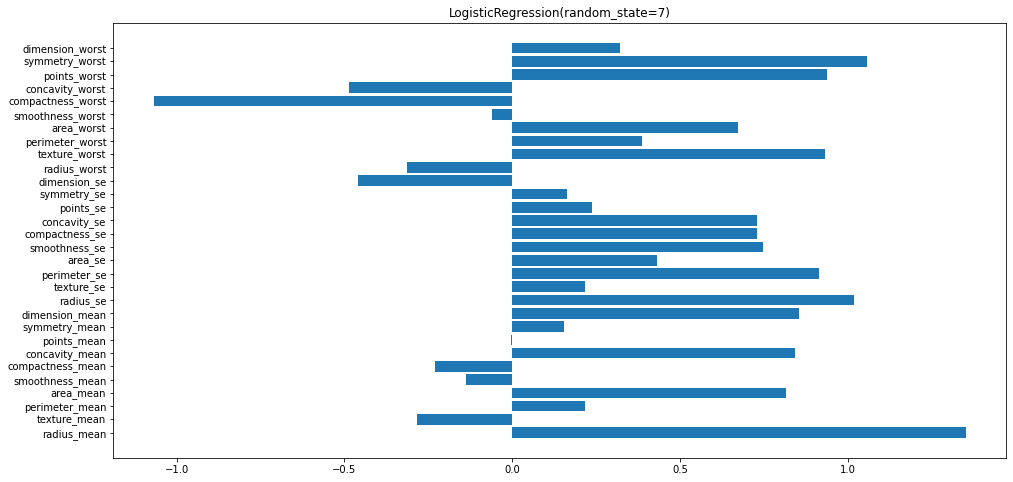

texture_worst        1.351348
area_se              1.057192
radius_se            1.019046
area_worst           0.937626
concavity_worst      0.932521
points_worst         0.915826
radius_worst         0.853712
smoothness_worst     0.843369
symmetry_worst       0.815450
points_mean          0.747118
perimeter_se         0.731175
perimeter_worst      0.729545
concavity_mean       0.671999
points_se            0.432465
concavity_se         0.387625
area_mean            0.322795
perimeter_mean       0.238519
radius_mean          0.217760
texture_mean         0.215855
dimension_worst      0.164873
smoothness_mean      0.153447
smoothness_se       -0.004786
compactness_worst   -0.060173
symmetry_se         -0.137605
symmetry_mean       -0.228898
texture_se          -0.283224
dimension_mean      -0.312911
dimension_se        -0.459262
compactness_mean    -0.487653
compactness_se      -1.067862
dtype: float64

In [15]:
models = ['RandomForestClassifier','SGDClassifier','LogisticRegression']
CL = 0.85
final_models = []  

for model in models:
  print(model)
  if model == 'RandomForestClassifier':
    model = RandomForestClassifier( n_estimators = 10, max_depth=7, random_state = 7)
    model.fit(X_train_scaled, y_train)
    final_models.append(model)
    importance = model.feature_importances_
  if model == 'SGDClassifier':
    model = SGDClassifier(loss = 'log',random_state = 7)
    model.fit(X_train_scaled, y_train)
    final_models.append(model)
    importance = model.coef_[0]
  if model == 'LogisticRegression':
    model = LogisticRegression(random_state = 7)
    model.fit(X_train_scaled, y_train)
    final_models.append(model)
    importance = model.coef_[0]
  

  train_preds = model.predict(X_train_scaled)
  test_preds = model.predict(X_test_scaled)

  print('\n')
  if metrics.accuracy_score(y_train, train_preds) > metrics.accuracy_score(y_test, test_preds) or metrics.accuracy_score(y_test, test_preds) < CL:
    
    print(f" {model} NO GOOD")
    print(f"{model} is not a Genralized Model. \n- We cannot consider this model for deployment. \
    \n- Either accuracy_score_test < accuracy_score_train OR accuracy_score_test < CL \n")
    print(f"accuracy_score_train: {metrics.accuracy_score(y_train, train_preds)}")
    print(f'accuracy_score_test: {metrics.accuracy_score(y_test, test_preds)}')
    print(f"CL decided: {CL}")
    print(f"No Further Action for model: {model}")
  if metrics.accuracy_score(y_train, train_preds) < metrics.accuracy_score(y_test, test_preds) and metrics.accuracy_score(y_test, test_preds) > CL: 

    print(f"{model} is generalized because accuracy_score_test > accuracy_score_train AND accuracy_score_test > CL")
    print(f'accuracy_score_train: {metrics.accuracy_score(y_train, train_preds)}')
    print(f'accuracy_score_test: {metrics.accuracy_score(y_test, test_preds)}')
    print(f"CL decided: {CL}")
    print('\n')
    print("Since Model is generalized. Let's check Confusion Matrix and Classification Report")
    print('\n')
    print(f"Classification report of Train Data: \n{metrics.classification_report(y_train, train_preds)}")
    print()
    print(f"Classification report of Test Data: \n{metrics.classification_report(y_test, test_preds)}")
    print('\n')
    print(f"Confusion Matrix of Train Data: \n{metrics.confusion_matrix(y_train, train_preds)}")
    print('\n')
    print(f"Confusion Matrix of Test Data: \n{metrics.confusion_matrix(y_test, test_preds)}")
    print('\n')

    # plot feature importance
    #reference: https://stackoverflow.com/questions/44511636/plot-feature-importance-with-feature-names
    feat_importances = pd.Series(importance, index=X_train.columns)

    plt.barh(feat_importances.index, feat_importances.sort_index(ascending = False).values )
    plt.title(model)
    plt.show()

    display(feat_importances.sort_values(ascending = False))
  print('\n')
  print('='*100)



## **Selecting Model-1:**
- **Logistic Regresssion** Model gave highest accuracy with test data and is generalized model.

In [16]:
X_scaled = scaler.transform(X)

In [27]:
model1 = LogisticRegression(random_state=7)
model1.fit(X_train_scaled,y_train)
pred = model1.predict(X_scaled)
print(f"Classification report of Train Data: \n{metrics.classification_report(Y, pred)}")
# print()
# print(f"Classification report of Test Data: \n{classification_report(Y, pred)}")
# print('\n')
# print(f"Confusion Matrix of Train Data: \n{confusion_matrix(Y, pred)}")
print('\n')
print(f"Confusion Matrix of Test Data: \n{metrics.confusion_matrix(Y, pred)}")
print('\n')

Classification report of Train Data: 
              precision    recall  f1-score   support

           B       0.98      1.00      0.99       357
           M       1.00      0.97      0.99       212

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569



Confusion Matrix of Test Data: 
[[357   0]
 [  6 206]]




## **Selecting a model using Visualization Matrix**

In [20]:
"""Performing Train-Test Split"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=4 )

"""Standardizing the data"""
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline


Test_AUC with RandomForestClassifier(max_depth=7, n_estimators=10, random_state=4): 0.982811509029916
Test_AUC with SGDClassifier(loss='log', random_state=4): 0.9956268701373151
Test_AUC with LogisticRegression(random_state=4): 0.9957708353455278


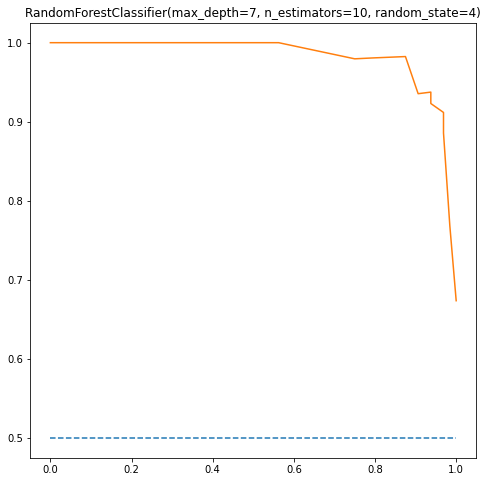

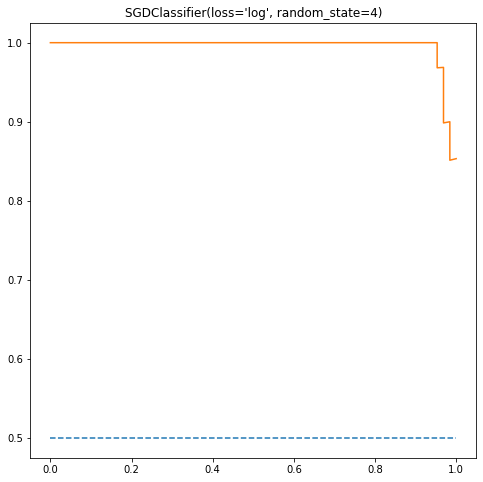

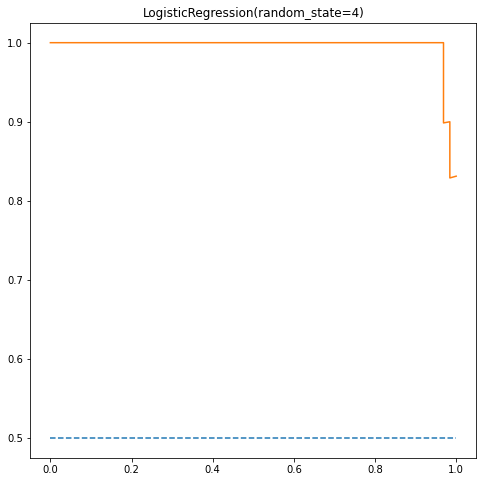

In [38]:
models = ['RandomForestClassifier','SGDClassifier','LogisticRegression']
CL = 0.85
final_models = []  

for model in models:
  if model == 'RandomForestClassifier':
    model = RandomForestClassifier( n_estimators = 10, max_depth=7, random_state = 4)
    model.fit(X_train_scaled, y_train)

  if model == 'SGDClassifier':
    model = SGDClassifier(loss = 'log',random_state = 4)
    model.fit(X_train_scaled, y_train)

  if model == 'LogisticRegression':
    model = LogisticRegression(random_state = 4)
    model.fit(X_train_scaled, y_train)

  train_preds = model.predict_proba(X_train_scaled)[:,1]
  test_preds = model.predict_proba(X_test_scaled)[:,1]

  pr_test,re_test,_ = precision_recall_curve(y_test,test_preds, pos_label = 'M')
  auc_test = auc(re_test, pr_test)

  plt.figure(figsize = (8,8))
  plt.plot([0,1],[0.5,0.5], linestyle='--')
  # plt.plot(re_train, pr_train)
  plt.plot(re_test, pr_test)
  plt.title(model)
  
  print(f"Test_AUC with {model}: {auc_test}")

## **Selecting Model-2** 
- **Logistic Regression**:
  - ROC curve is above skill-line. Therefore, Full-Skill curve.
  - Next we checked knowledge. Since AUC is above CL + 0.05, we can accept the model.
- Let's check the model with whole data.


Whole_data_AUC with LogisticRegression(random_state=4): 0.9964686192559821



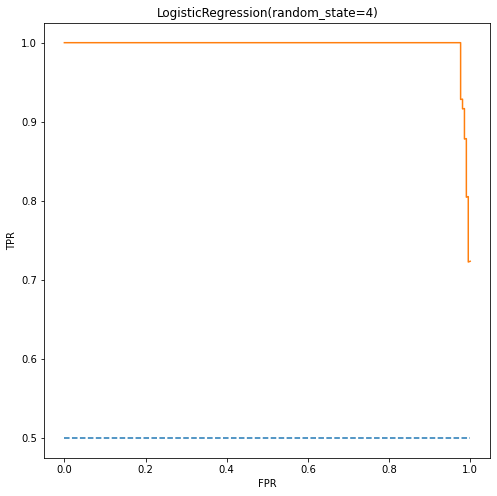

In [26]:
X_scaled = scaler.transform(X)
model2 = LogisticRegression(random_state = 4)
model2.fit(X_train_scaled, y_train)
pred = model2.predict_proba(X_scaled)[:,1]


precision,recall,_ = precision_recall_curve(Y,pred, pos_label = 'M')
auc_whole_data = auc(recall, precision)

print(f"Whole_data_AUC with {model2}: {auc_whole_data}\n")
plt.figure(figsize = (8,8))
plt.plot([0,1],[0.5,0.5], linestyle='--')
plt.plot(recall, precision)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(model2);



# **10. Let's use some methods from ``sklearn.feature_selection``**
- **Using ``RFE`` and ``SelectFromModel`` to select top-2 features.** 

In [28]:
from sklearn.feature_selection import RFE, SelectFromModel

In [39]:
"""Setting up data for train-test split"""
X = df.drop(['diagnosis'], axis =1)
Y = df.diagnosis 

"""Performing Train-Test Split"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=10 )

"""Standardizing the data"""
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [40]:
"""RFE: Recursive Feature Elimination."""
# referene: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE
estimators  = [model1, model2]
for estimator in estimators:
  print(f"present Model: {estimator}")
  selector = RFE(estimator, n_features_to_select=2, step=1)
  selector = selector.fit(X_train_scaled, y_train)
  print(f"Top-2 Features as per order of X_train.columns shown as 'True': \n{selector.support_}\n")

  print(f"Ranked-index of Features. Top two features are marked as 1, order is same as X_train.columns: \n{selector.ranking_}\n")

  print(f"X_train.columns: \n{list(X_train_scaled.columns)}\n")

  print(f"Top-2 features after RFE: \n{selector.get_feature_names_out()}\n")
  print("="*100)



present Model: LogisticRegression(random_state=7)
Top-2 Features as per order of X_train.columns shown as 'True': 
[False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False  True False False]

Ranked-index of Features. Top two features are marked as 1, order is same as X_train.columns: 
[18  3 15 12 24 23 17  4 26 22  8 28 16  2 25  6 19 13 27 20  1 11  7  9
 10 29  5  1 14 21]

X_train.columns: 
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'points_se', 'symmetry_se', 'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_wor

In [30]:
"""Select From Model: Meta-transformer for selecting features based on importance weights."""
# referene: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel
estimators  = [model1,model2]
for estimator in estimators:
  print(f"Present Model: {estimator}")
  selector1 = SelectFromModel(estimator=estimator, max_features=2).fit(X_train_scaled, y_train)

  print(f"Coefficients used: \n{selector1.estimator_.coef_}\n")

  print(f"Thresholds used \n{selector1.threshold_}\n")

  print(f"X_train.columns: \n{list(X_train.columns)}\n")

  print(f"Top features to be selected shown in True and False  \n{selector1.get_support()}\n")

  print(f"Top-2 features after Select_From_Model: \n{selector1.get_feature_names_out()}\n")
  print("="*100)



Present Model: LogisticRegression(random_state=7)
Coefficients used: 
[[ 0.29213405  0.5391146   0.32238208  0.39964476  0.21150421 -0.42246468
   0.7116301   0.89512521 -0.2772841  -0.32003971  1.15946115 -0.14519349
   0.69215941  1.04197335  0.02571829 -1.09492727  0.38266651  0.43887851
  -0.04702436 -0.41843557  0.85433117  0.99567075  0.79300331  0.86252743
   0.91369824 -0.2849565   0.49095069  0.9470743   0.77497509  0.64182975]]

Thresholds used 
0.5798926220305148

X_train.columns: 
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'points_se', 'symmetry_se', 'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_worst']

Top

## **Observations:** 
- From model1 we got:
  - RFE: **'area_worst' and 'points_worst'**
  - Select_From_Model: **'radius_se' and 'compactness_se'**
- From model2 we got: 
  - RFE: **'area_worst' and 'points_worst'**
  - Select_From_Model: **'radius_se' and 'compactness_se'**
- Now let's use these combination and compare the results.


# **11. Train models using top-2 Variables combinations**
- Select the best 2 variables:
  - Check if model is still generalized
  - Can model be deployed? i.e. test_prediction_score > CL decided




In [49]:
RFE_var =  ['area_worst' ,'points_worst']
select_from_model_var = [  'radius_se' , 'compactness_se']

### **Using Logistic Regression and combination of top-2 variables selected by different methods.**

In [ ]:

"""Setting up data for train-test split"""
X = df[RFE_var]
Y = df.diagnosis 

"""Performing Train-Test Split"""
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state=10 )

"""Standardizing the data"""
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [59]:
scaler = StandardScaler()

In [70]:
dict_variables_log_reg = {'RFE_var': ['area_worst' ,'points_worst'],
                          'select_from_model_var': [  'radius_se' , 'compactness_se']}
for key, val in dict_variables_log_reg.items():
  for i in range(0,30):
    if key == 'RFE_var':
      X_train, X_test, y_train, y_test = train_test_split(df[RFE_var], df['diagnosis'], test_size = 0.3,  random_state=i )
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
    elif key == 'select_from_model_var':
      X_train, X_test, y_train, y_test = train_test_split(df[select_from_model_var], df['diagnosis'], test_size = 0.3,  random_state=i )
      X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
      X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
    


    model1.fit(X_train_scaled, y_train)
    train_preds = model1.predict(X_train_scaled)
    test_preds = model1.predict(X_test_scaled)
    tr_acc = metrics.accuracy_score(y_train, train_preds)
    ts_acc = metrics.accuracy_score(y_test, test_preds)
    if tr_acc < ts_acc and ts_acc > CL:

      print(i,key,val)
      print(f"Accuracy_of_train: {tr_acc}")
      print(f"Accuracy_of_test: {ts_acc}")
      print(f"CL decided: {CL}")

    
      print('\n')

      print(f"Classification report of Train Data: \n{metrics.classification_report(y_train, train_preds)}")
      print()
      print(f"Classification report of Test Data: \n{metrics.classification_report(y_test, test_preds)}")
      print('\n')
      print(f"Confusion Matrix of Train Data: \n{metrics.confusion_matrix(y_train, train_preds)}")
      print('\n')
      print(f"Confusion Matrix of Test Data: \n{metrics.confusion_matrix(y_test, test_preds)}\n")
      print("="*50)
      print('\n')

1 RFE_var ['area_worst', 'points_worst']
Accuracy_of_train: 0.949748743718593
Accuracy_of_test: 0.9590643274853801
CL decided: 0.85


Classification report of Train Data: 
              precision    recall  f1-score   support

           B       0.95      0.97      0.96       243
           M       0.95      0.92      0.93       155

    accuracy                           0.95       398
   macro avg       0.95      0.94      0.95       398
weighted avg       0.95      0.95      0.95       398


Classification report of Test Data: 
              precision    recall  f1-score   support

           B       0.95      0.99      0.97       114
           M       0.98      0.89      0.94        57

    accuracy                           0.96       171
   macro avg       0.97      0.94      0.95       171
weighted avg       0.96      0.96      0.96       171



Confusion Matrix of Train Data: 
[[236   7]
 [ 13 142]]


Confusion Matrix of Test Data: 
[[113   1]
 [  6  51]]



6 RFE_var ['area_w

In [72]:
dict_variables_log_reg = {'RFE_var': ['area_worst' ,'points_worst'],
                          'select_from_model_var': [  'radius_se' , 'compactness_se']}
for key, val in dict_variables_log_reg.items():
  for i in range(0,30):
    if key == 'RFE_var':
      X_train, X_test, y_train, y_test = train_test_split(df[RFE_var], df['diagnosis'], test_size = 0.3,  random_state=i )
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
    elif key == 'select_from_model_var':
      X_train, X_test, y_train, y_test = train_test_split(df[select_from_model_var], df['diagnosis'], test_size = 0.3,  random_state=i )
      X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
      X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
    


    model2.fit(X_train_scaled, y_train)
    train_preds = model2.predict(X_train_scaled)
    test_preds = model2.predict(X_test_scaled)
    tr_acc = metrics.accuracy_score(y_train, train_preds)
    ts_acc = metrics.accuracy_score(y_test, test_preds)
    if tr_acc < ts_acc and ts_acc > CL:

      print(i,key,val)
      print(f"Accuracy_of_train: {tr_acc}")
      print(f"Accuracy_of_test: {ts_acc}")
      print(f"CL decided: {CL}")

    
      print('\n')

      print(f"Classification report of Train Data: \n{metrics.classification_report(y_train, train_preds)}")
      print()
      print(f"Classification report of Test Data: \n{metrics.classification_report(y_test, test_preds)}")
      print('\n')
      print(f"Confusion Matrix of Train Data: \n{metrics.confusion_matrix(y_train, train_preds)}")
      print('\n')
      print(f"Confusion Matrix of Test Data: \n{metrics.confusion_matrix(y_test, test_preds)}\n")
      print("="*50)
      print('\n')

1 RFE_var ['area_worst', 'points_worst']
Accuracy_of_train: 0.949748743718593
Accuracy_of_test: 0.9590643274853801
CL decided: 0.85


Classification report of Train Data: 
              precision    recall  f1-score   support

           B       0.95      0.97      0.96       243
           M       0.95      0.92      0.93       155

    accuracy                           0.95       398
   macro avg       0.95      0.94      0.95       398
weighted avg       0.95      0.95      0.95       398


Classification report of Test Data: 
              precision    recall  f1-score   support

           B       0.95      0.99      0.97       114
           M       0.98      0.89      0.94        57

    accuracy                           0.96       171
   macro avg       0.97      0.94      0.95       171
weighted avg       0.96      0.96      0.96       171



Confusion Matrix of Train Data: 
[[236   7]
 [ 13 142]]


Confusion Matrix of Test Data: 
[[113   1]
 [  6  51]]



6 RFE_var ['area_w

## **Final 2-features selected:**
- **'area_worst', 'points_worst'** using RFE method using model1 got better result hence selecting that for plotting the decision boundary

In [91]:
Y= df.diagnosis.apply(lambda x: 1 if x=='B' else 0)


LogisticRegression(random_state=7)

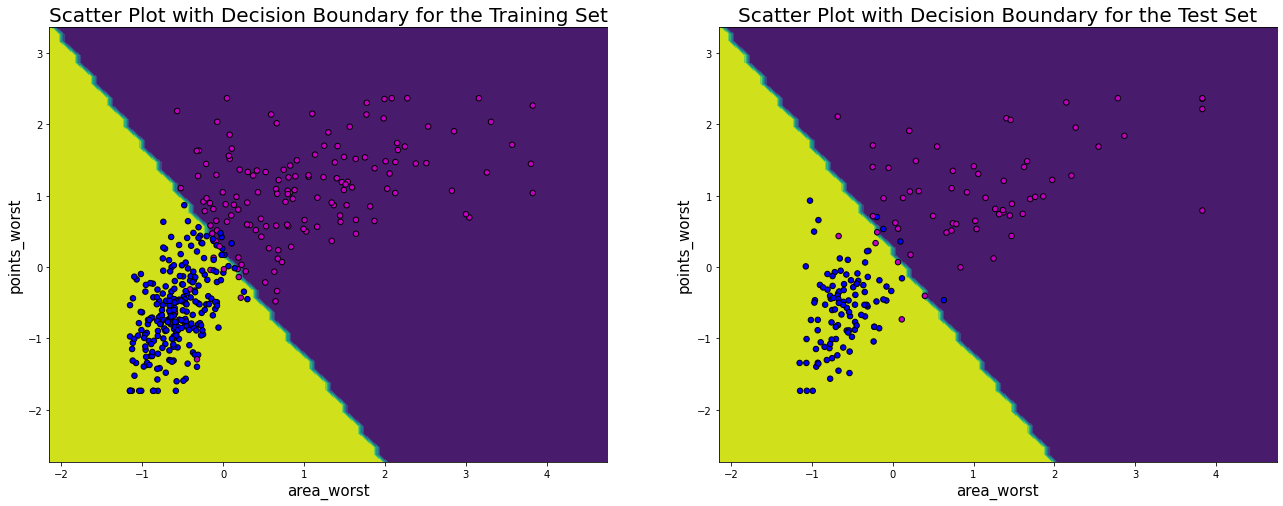

In [108]:
# Reference: https://favtutor.com/blogs/decision-boundary-logistic-regression
RFE_var = ['area_worst' ,'points_worst']

X_train, X_test, ytrain, ytest = train_test_split(df[RFE_var], Y, test_size = 0.3,  random_state=i )
xtrain = scaler.fit_transform(X_train)
xtest = scaler.transform(X_test)

model_plot = LogisticRegression(random_state= 7)
model_plot.fit(xtrain, ytrain)

train_preds = model_plot.predict_proba(xtrain)[:,1]
test_preds = model_plot.predict_proba(xtest)[:,1]


# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_plot.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)


x_min, x_max = xtest[:, 0].min() - 1, xtest[:, 0].max() + 1
y_min, y_max = xtest[:, 1].min() - 1, xtest[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_plot.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)

plt.figure(figsize = (22, 8))
plt.subplot(1, 2, 1)
plt.contourf(xx_train, yy_train, Z_train)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c = y_train, s = 30, edgecolor = 'k')
plt.xlabel(f'{RFE_var[0]}', fontsize = 15)
plt.ylabel(f'{RFE_var[1]}', fontsize = 15)
plt.title('Scatter Plot with Decision Boundary for the Training Set', fontsize = 20)
plt.subplot(1, 2, 2)
plt.contourf(xx_test, yy_test, Z_test)
plt.scatter(xtest[:, 0], xtest[:, 1], c = y_test, s = 30, edgecolor = 'k')
plt.xlabel(f'{RFE_var[0]}', fontsize = 15)
plt.ylabel(f'{RFE_var[1]}', fontsize = 15)
plt.title('Scatter Plot with Decision Boundary for the Test Set', fontsize = 20)
plt.show()

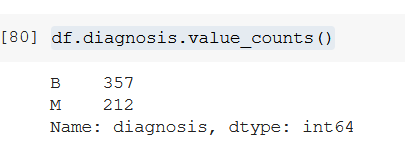


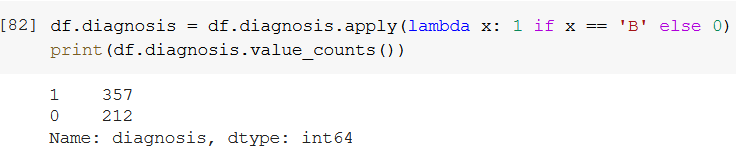

# **13. Deployment Code:**
- Let's randomly take a row from scaled_data and try to predict the result.
- Next we can randomly give some valid values to the model and observe its prediction.

In [109]:
final_models = [model1, model2]
final_models

[LogisticRegression(random_state=7), LogisticRegression(random_state=4)]

In [110]:
# some_0_or_M_index: 5,14,15,16,20
# some_1_or_B_index: 0,1,2,3,4

In [117]:
RFE_var

['area_worst', 'points_worst']

In [126]:
index_ =4
query_data = df[RFE_var].iloc[index_]
print(f"Query_data: \n{query_data}\n")
print(f"Original Decision: {df.diagnosis.iloc[index_]}")

Query_data: 
area_worst      819.10000
points_worst      0.08178
Name: 4, dtype: float64

Original Decision: B


In [132]:
scaled_query_data = scaler.transform(query_data.values.reshape(1,-1))

In [136]:
for final_model in final_models:
  print(f"Present Model: {final_model}")
  decision = "1 or B"
  print(f"Predicted Label: \n{final_model.predict(scaled_query_data)}")
  print(f"Prediction Probability: {final_model.predict_proba(scaled_query_data)[:,1][0]}")
  print("="*50)

Present Model: LogisticRegression(random_state=7)
Predicted Label: 
['B']
Prediction Probability: 0.3109503230281969
Present Model: LogisticRegression(random_state=4)
Predicted Label: 
['B']
Prediction Probability: 0.3109503230281969


### **Prediction on Random data**


In [145]:
area_worst = float(input("Enter a float for area_worst: "))
points_worst = float(input("Enter a float for points_worst: "))
query_data = scaler.transform(np.array([area_worst, points_worst]).reshape(1,-1))
print(f"\n0.Query data Entered: {area_worst, points_worst}\n")

for final_model in final_models:
  print(f"Present Model: {final_model}")
  decision = "1 or B"
  print(f"Predicted Label: {final_model.predict(query_data)[0]}")
  print(f"Prediction Probability: {final_model.predict_proba(query_data)[:,1][0]}")
  print("="*50)

Enter a float for area_worst: 800
Enter a float for points_worst: 05

Query data Entered: (800.0, 5.0)

Present Model: LogisticRegression(random_state=7)
Predicted Label: M
Prediction Probability: 0.9999999998782085
Present Model: LogisticRegression(random_state=4)
Predicted Label: M
Prediction Probability: 0.9999999998782085
